In [ ]:
# Auther: Tzu-Han Hsu

# BSD 3-Clause License

# Copyright (c) 2022, Anywhere Door Lab (ADL) and Tzu-Han Hsu
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import math
import pickle
from torchsummary import summary
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vital params

dataset_name="caltech101"
 
model_name="EfficientNetb6"
version = "b6"

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

phi, res, drop_rate = phi_values[version]
#hyperparameters
batch_size=2
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(224,224)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
elif dataset_name == "caltech101":
    num_classes=101
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "caltech101":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/caltech101"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [7477, 1200])
    train_set, test_set = data.random_split(train_set,[6277, 1200])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    
    
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")


Model: EfficientNetb6 with 101 classes running on: caltech101
Dataset size: Train: 6277, Valid: 1200, Test: 1200
{'Faces': 0, 'Faces_easy': 1, 'Leopards': 2, 'Motorbikes': 3, 'accordion': 4, 'airplanes': 5, 'anchor': 6, 'ant': 7, 'barrel': 8, 'bass': 9, 'beaver': 10, 'binocular': 11, 'bonsai': 12, 'brain': 13, 'brontosaurus': 14, 'buddha': 15, 'butterfly': 16, 'camera': 17, 'cannon': 18, 'car_side': 19, 'ceiling_fan': 20, 'cellphone': 21, 'chair': 22, 'chandelier': 23, 'cougar_body': 24, 'cougar_face': 25, 'crab': 26, 'crayfish': 27, 'crocodile': 28, 'crocodile_head': 29, 'cup': 30, 'dalmatian': 31, 'dollar_bill': 32, 'dolphin': 33, 'dragonfly': 34, 'electric_guitar': 35, 'elephant': 36, 'emu': 37, 'euphonium': 38, 'ewer': 39, 'ferry': 40, 'flamingo': 41, 'flamingo_head': 42, 'garfield': 43, 'gerenuk': 44, 'gramophone': 45, 'grand_piano': 46, 'hawksbill': 47, 'headphone': 48, 'hedgehog': 49, 'helicopter': 50, 'ibis': 51, 'inline_skate': 52, 'joshua_tree': 53, 'kangaroo': 54, 'ketch': 5

In [2]:
class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = math.ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*math.ceil(int(channels*width_factor) / 4)
            layers_repeats = math.ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

In [3]:
model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)

from thop import profile
import colorama
from colorama import Fore,Style
#vital params
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3, res, res).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)

#pretesting model for shape
x=torch.randn(batch_size,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print(summary(model, input_size=(3, res, res)))
print("model shape ready")

#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print("model initialised")

[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CNNBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Sigmoid'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.SqueezeExcitation'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.InvertedResidualBlock'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_l

C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


The model requires: 70.1127 GFLOPS

torch.Size([2, 3, 528, 528])
torch.Size([2, 101])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 51, 264, 264]           1,377
       BatchNorm2d-2         [-1, 51, 264, 264]             102
              SiLU-3         [-1, 51, 264, 264]               0
          CNNBlock-4         [-1, 51, 264, 264]               0
            Conv2d-5         [-1, 51, 264, 264]             459
       BatchNorm2d-6         [-1, 51, 264, 264]             102
              SiLU-7         [-1, 51, 264, 264]               0
          CNNBlock-8         [-1, 51, 264, 264]               0
 AdaptiveAvgPool2d-9             [-1, 51, 1, 1]               0
           Conv2d-10             [-1, 12, 1, 1]             624
             SiLU-11             [-1, 12, 1, 1]               0
           Conv2d-12             [-1, 51, 1, 1]             663
          Sigmoid

In [4]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [5]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string:")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs/EfficientNetb620211231002459
grandstore_string:
grandstore/caltech101_EfficientNetb620211231002459.pkl


In [6]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [7]:
TOP_ACCURACY_TRACK = 5
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=240,
                    minepoch=120,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                  
                   )

Running epoch: 1


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.667
Training Loss: 43041484.8526 	Validation Loss: 5154.9898

Running epoch: 2


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.250
Training Loss: 41910559.7668 	Validation Loss: 5152.8030

Running epoch: 3


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 8.417
Training Loss: 41893971.6272 	Validation Loss: 5107.3329

Running epoch: 4


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 8.000
Training Loss: 41898519.0510 	Validation Loss: 5180.1263

Running epoch: 5


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 8.750
Training Loss: 41861043.0341 	Validation Loss: 5108.9586

Running epoch: 6


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 7.250
Training Loss: 41936053.5428 	Validation Loss: 5123.5373

Running epoch: 7


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 8.750
Training Loss: 41899536.7680 	Validation Loss: 6728.6160

Running epoch: 8


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 8.583
Training Loss: 41851006.1212 	Validation Loss: 5127.0577

Running epoch: 9


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 8.833
Training Loss: 41931567.5314 	Validation Loss: 5125.6212

Running epoch: 10


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 8.833
Training Loss: 41873090.2488 	Validation Loss: 5121.1913

Running epoch: 11


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 11.500
Training Loss: 41982906.2075 	Validation Loss: 5110.0540

Running epoch: 12


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.167
Training Loss: 41879519.4711 	Validation Loss: 5112.0041

Running epoch: 13


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.917
Training Loss: 41974728.6755 	Validation Loss: 5109.9923

Running epoch: 14


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.500
Training Loss: 41808473.6831 	Validation Loss: 5128.6933

Running epoch: 15


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.833
Training Loss: 41658604.1934 	Validation Loss: 5110.7575

Running epoch: 16


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 10.917
Training Loss: 41842139.2169 	Validation Loss: 5122.8826

Running epoch: 17


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.500
Training Loss: 41916511.0804 	Validation Loss: 5131.6125

Running epoch: 18


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.583
Training Loss: 41803854.6824 	Validation Loss: 5126.7447

Running epoch: 19


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 9.917
Training Loss: 41723531.3308 	Validation Loss: 5104.2096

Running epoch: 20


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.667
Training Loss: 41699719.2007 	Validation Loss: 5126.7592

Running epoch: 21


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 11.000
Training Loss: 41633089.3044 	Validation Loss: 5044.0726

Running epoch: 22


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.500
Training Loss: 41702571.9935 	Validation Loss: 5099.1967

Running epoch: 23


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.833
Training Loss: 41924575.6837 	Validation Loss: 5122.6276

Running epoch: 24


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.500
Training Loss: 41781725.3269 	Validation Loss: 5124.8526

Running epoch: 25


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 11.500
Training Loss: 41617205.2931 	Validation Loss: 5086.9967

Running epoch: 26


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 11.333
Training Loss: 41514119.3220 	Validation Loss: 5116.5569

Running epoch: 27


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.917
Training Loss: 41629735.9274 	Validation Loss: 5060.7055

Running epoch: 28


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 12.667
Training Loss: 41594668.0088 	Validation Loss: 5040.7925

Running epoch: 29


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 11.500
Training Loss: 41277570.2952 	Validation Loss: 5113.9522

Running epoch: 30


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.667
Training Loss: 41492217.6811 	Validation Loss: 5093.0357

Running epoch: 31


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.583
Training Loss: 41790294.2448 	Validation Loss: 5127.1743

Running epoch: 32


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 9.417
Training Loss: 41980784.1054 	Validation Loss: 5132.4955

Running epoch: 33


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 10.833
Training Loss: 41725881.9123 	Validation Loss: 5135.9431

Running epoch: 34


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.833
Training Loss: 41895542.8123 	Validation Loss: 5137.0414

Running epoch: 35


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.167
Training Loss: 41857029.4068 	Validation Loss: 5146.4699

Running epoch: 36


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 7.083
Training Loss: 41723482.1023 	Validation Loss: 5213.1155

Running epoch: 37


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.833
Training Loss: 41636535.9552 	Validation Loss: 5128.0854

Running epoch: 38


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 13.000
Training Loss: 41707583.6613 	Validation Loss: 5066.4797

Running epoch: 39


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 9.583
Training Loss: 41763235.4804 	Validation Loss: 5213.1166

Running epoch: 40


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 8.583
Training Loss: 41707364.0745 	Validation Loss: 5731.3042

Running epoch: 41


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 6.583
Training Loss: 41528171.5020 	Validation Loss: 5154.5459

Running epoch: 42


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 12.583
Training Loss: 41302495.2702 	Validation Loss: 5052.3166

Running epoch: 43


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 13.250
Training Loss: 40933491.7899 	Validation Loss: 4993.3744

Running epoch: 44


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 13.500
Training Loss: 39979222.2639 	Validation Loss: 4949.0328

Running epoch: 45


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 17.000
Training Loss: 39632117.9427 	Validation Loss: 4924.0829

Running epoch: 46


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 16.417
Training Loss: 39240362.7536 	Validation Loss: 4780.5888

Running epoch: 47


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 15.417
Training Loss: 38915495.9016 	Validation Loss: 4830.6452

Running epoch: 48


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 24.167
Training Loss: 37828519.7079 	Validation Loss: 4465.0198

Running epoch: 49


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 26.917
Training Loss: 35966964.9773 	Validation Loss: 4301.4320

Running epoch: 50


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 29.333
Training Loss: 34308035.5962 	Validation Loss: 3922.2550

Running epoch: 51


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 30.417
Training Loss: 32960369.5410 	Validation Loss: 3813.1515

Running epoch: 52


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 33.333
Training Loss: 31661361.1938 	Validation Loss: 3602.8333

Running epoch: 53


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 37.250
Training Loss: 30240027.1289 	Validation Loss: 3446.5596

Running epoch: 54


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 37.000
Training Loss: 29233689.3387 	Validation Loss: 3406.4561

Running epoch: 55


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 40.333
Training Loss: 28668746.7872 	Validation Loss: 3291.8569

Running epoch: 56


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 40.833
Training Loss: 27877242.0123 	Validation Loss: 3203.0334

Running epoch: 57


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 42.750
Training Loss: 26948611.1153 	Validation Loss: 3060.3596

Running epoch: 58


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 43.750
Training Loss: 26178880.3618 	Validation Loss: 3051.2125

Running epoch: 59


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 43.083
Training Loss: 25302625.2256 	Validation Loss: 3172.2233

Running epoch: 60


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 46.167
Training Loss: 24381835.9768 	Validation Loss: 2884.0288

Running epoch: 61


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 45.417
Training Loss: 23273235.1760 	Validation Loss: 2902.5429

Running epoch: 62


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 46.333
Training Loss: 22922619.7158 	Validation Loss: 2831.4207

Running epoch: 63


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 48.667
Training Loss: 22337891.0839 	Validation Loss: 2799.7520

Running epoch: 64


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 47.417
Training Loss: 21016643.0131 	Validation Loss: 2959.5690

Running epoch: 65


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.583
Training Loss: 20340797.2591 	Validation Loss: 2722.5165

Running epoch: 66


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 49.333
Training Loss: 20040136.9249 	Validation Loss: 2718.3251

Running epoch: 67


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 52.417
Training Loss: 18878128.5574 	Validation Loss: 2552.9548

Running epoch: 68


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 51.500
Training Loss: 18264812.4228 	Validation Loss: 2637.8990

Running epoch: 69


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 51.917
Training Loss: 17736235.1499 	Validation Loss: 2597.5139

Running epoch: 70


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 52.750
Training Loss: 17010085.2090 	Validation Loss: 2532.3496

Running epoch: 71


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 53.500
Training Loss: 16193708.4873 	Validation Loss: 2555.7858

Running epoch: 72


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 56.750
Training Loss: 15446443.4930 	Validation Loss: 2382.1827

Running epoch: 73


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 55.083
Training Loss: 14813428.3019 	Validation Loss: 2590.4088

Running epoch: 74


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 54.917
Training Loss: 14173857.4335 	Validation Loss: 2424.9652

Running epoch: 75


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 56.333
Training Loss: 13201331.6024 	Validation Loss: 2540.8646

Running epoch: 76


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 57.250
Training Loss: 12624520.4983 	Validation Loss: 2501.0192

Running epoch: 77


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 55.833
Training Loss: 11967429.7450 	Validation Loss: 2755.0989

Running epoch: 78


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 58.250
Training Loss: 11129640.6019 	Validation Loss: 2487.9101

Running epoch: 79


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 56.917
Training Loss: 10465380.5897 	Validation Loss: 2695.7945

Running epoch: 80


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 57.750
Training Loss: 9690145.7327 	Validation Loss: 2485.5248

Running epoch: 81


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 56.250
Training Loss: 9318631.0437 	Validation Loss: 2714.2677

Running epoch: 82


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 58.417
Training Loss: 8590570.3477 	Validation Loss: 2712.1062

Running epoch: 83


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 57.167
Training Loss: 7894036.1048 	Validation Loss: 2774.7925

Running epoch: 84


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.000
Training Loss: 7195054.7544 	Validation Loss: 2666.7484

Running epoch: 85


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 57.667
Training Loss: 7072770.8744 	Validation Loss: 2909.1211

Running epoch: 86


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 57.917
Training Loss: 6474205.3102 	Validation Loss: 2919.3932

Running epoch: 87


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 56.917
Training Loss: 5663808.1134 	Validation Loss: 2994.2999

Running epoch: 88


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 57.333
Training Loss: 5568319.5017 	Validation Loss: 3039.3270

Running epoch: 89


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 57.083
Training Loss: 4831324.6594 	Validation Loss: 3231.8443

Running epoch: 90


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 54.667
Training Loss: 4584038.2053 	Validation Loss: 3299.0764

Running epoch: 91


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 57.750
Training Loss: 4449877.5113 	Validation Loss: 3211.0910

Running epoch: 92


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 57.250
Training Loss: 3964196.5987 	Validation Loss: 3260.1601

Running epoch: 93


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 56.000
Training Loss: 3612198.2616 	Validation Loss: 3352.9044

Running epoch: 94


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 58.167
Training Loss: 3414627.8795 	Validation Loss: 3188.0863

Running epoch: 95


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.167
Training Loss: 3348736.5785 	Validation Loss: 3362.8689

Running epoch: 96


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 57.083
Training Loss: 3249131.6058 	Validation Loss: 3489.7177

Running epoch: 97


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.250
Training Loss: 2967370.0486 	Validation Loss: 3502.8085

Running epoch: 98


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.833
Training Loss: 2675768.0468 	Validation Loss: 3402.2370

Running epoch: 99


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 56.500
Training Loss: 2651106.6094 	Validation Loss: 3679.4511

Running epoch: 100


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.167
Training Loss: 2658248.8209 	Validation Loss: 3845.9668

Running epoch: 101


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 57.750
Training Loss: 2303749.5856 	Validation Loss: 3633.8885

Running epoch: 102


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.500
Training Loss: 2255857.4904 	Validation Loss: 4108.2670

Running epoch: 103


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.333
Training Loss: 2330911.9163 	Validation Loss: 3971.0498

Running epoch: 104


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.083
Training Loss: 2023872.6670 	Validation Loss: 3824.8912

Running epoch: 105


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.333
Training Loss: 1970680.7595 	Validation Loss: 4002.4541

Running epoch: 106


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 56.500
Training Loss: 2006995.7903 	Validation Loss: 4060.4419

Running epoch: 107


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 57.833
Training Loss: 1671957.6817 	Validation Loss: 3845.7799

Running epoch: 108


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.333
Training Loss: 1960415.4843 	Validation Loss: 4027.7404

Running epoch: 109


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 57.500
Training Loss: 1722877.6359 	Validation Loss: 4516.5939

Running epoch: 110


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.083
Training Loss: 1810098.5529 	Validation Loss: 4232.8186

Running epoch: 111


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.583
Training Loss: 1634710.0630 	Validation Loss: 3959.8303

Running epoch: 112


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.250
Training Loss: 1688959.7091 	Validation Loss: 4165.1377

Running epoch: 113


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.167
Training Loss: 1738049.5416 	Validation Loss: 4177.9774

Running epoch: 114


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.750
Training Loss: 1645368.4630 	Validation Loss: 4036.3971

Running epoch: 115


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.833
Training Loss: 1384595.2598 	Validation Loss: 4370.8948

Running epoch: 116


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.917
Training Loss: 1646291.9685 	Validation Loss: 4121.7556

Running epoch: 117


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.333
Training Loss: 1484387.1924 	Validation Loss: 4404.1660

Running epoch: 118


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.667
Training Loss: 1405414.6316 	Validation Loss: 4155.8168

Running epoch: 119


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.583
Training Loss: 1393683.7419 	Validation Loss: 4221.2264

Running epoch: 120


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.333
Training Loss: 1342676.0441 	Validation Loss: 4264.7448

Running epoch: 121


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.333
Training Loss: 1429497.9867 	Validation Loss: 4411.5755

Running epoch: 122


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.000
Training Loss: 1323791.0279 	Validation Loss: 4314.2189

Running epoch: 123


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 57.750
Training Loss: 1239031.6954 	Validation Loss: 4362.9101

Running epoch: 124


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.333
Training Loss: 1316464.3134 	Validation Loss: 4366.0508

Running epoch: 125


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.583
Training Loss: 1275789.6289 	Validation Loss: 4197.1050

Running epoch: 126


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.333
Training Loss: 1087899.2539 	Validation Loss: 4488.5280

Running epoch: 127


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.500
Training Loss: 1301910.8463 	Validation Loss: 4522.3919

Running epoch: 128


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.167
Training Loss: 1254384.3769 	Validation Loss: 4463.0641

Running epoch: 129


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.833
Training Loss: 1188910.5567 	Validation Loss: 4591.4561

Running epoch: 130


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.167
Training Loss: 1110490.4972 	Validation Loss: 4577.8152

Running epoch: 131


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.000
Training Loss: 1223117.4142 	Validation Loss: 4341.2945

Running epoch: 132


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.250
Training Loss: 1016208.4486 	Validation Loss: 4656.1168

Running epoch: 133


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.167
Training Loss: 1218026.9264 	Validation Loss: 4546.5384

Running epoch: 134


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.417
Training Loss: 1050719.0579 	Validation Loss: 5050.6224

Running epoch: 135


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.500
Training Loss: 1179771.3146 	Validation Loss: 4457.2840

Running epoch: 136


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 59.750
Training Loss: 1131184.3946 	Validation Loss: 4529.2698

Running epoch: 137


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 56.667
Training Loss: 1121790.7726 	Validation Loss: 4813.3787

Running epoch: 138


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.583
Training Loss: 1009913.2671 	Validation Loss: 4366.4289

Running epoch: 139


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.250
Training Loss: 904902.2661 	Validation Loss: 4494.4286

Running epoch: 140


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.500
Training Loss: 1063618.4896 	Validation Loss: 4590.7333

Running epoch: 141


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.750
Training Loss: 1001915.4148 	Validation Loss: 4926.5855

Running epoch: 142


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.250
Training Loss: 796441.1282 	Validation Loss: 4784.1765

Running epoch: 143


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.250
Training Loss: 820738.5232 	Validation Loss: 4718.1110

Running epoch: 144


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.833
Training Loss: 1117294.4440 	Validation Loss: 4877.9781

Running epoch: 145


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.583
Training Loss: 929483.0031 	Validation Loss: 4983.6594

Running epoch: 146


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.000
Training Loss: 896278.2359 	Validation Loss: 4783.6647

Running epoch: 147


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.417
Training Loss: 942257.2275 	Validation Loss: 5021.3154

Running epoch: 148


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.917
Training Loss: 1033036.0672 	Validation Loss: 4987.6907

Running epoch: 149


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.250
Training Loss: 670240.8755 	Validation Loss: 5148.8665

Running epoch: 150


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.917
Training Loss: 993085.7127 	Validation Loss: 5134.5835

Running epoch: 151


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.583
Training Loss: 837747.1019 	Validation Loss: 4859.6212

Running epoch: 152


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.417
Training Loss: 883454.2185 	Validation Loss: 5019.3764

Running epoch: 153


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.667
Training Loss: 1085454.8006 	Validation Loss: 4892.0824

Running epoch: 154


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.667
Training Loss: 801471.2007 	Validation Loss: 5260.5969

Running epoch: 155


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.167
Training Loss: 855205.1358 	Validation Loss: 5401.1617

Running epoch: 156


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 57.667
Training Loss: 931338.8207 	Validation Loss: 5338.9535

Running epoch: 157


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.667
Training Loss: 815496.1195 	Validation Loss: 4847.0176

Running epoch: 158


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.000
Training Loss: 656461.9519 	Validation Loss: 5082.3699

Running epoch: 159


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.917
Training Loss: 806686.2229 	Validation Loss: 5085.8314

Running epoch: 160


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.750
Training Loss: 784667.9405 	Validation Loss: 5261.0661

Running epoch: 161


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.750
Training Loss: 773110.4759 	Validation Loss: 5263.7585

Running epoch: 162


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.583
Training Loss: 710950.4889 	Validation Loss: 5141.1658

Running epoch: 163


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 55.583
Training Loss: 837121.1970 	Validation Loss: 5695.5405

Running epoch: 164


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.917
Training Loss: 855506.1373 	Validation Loss: 5382.8453

Running epoch: 165


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.500
Training Loss: 641647.3495 	Validation Loss: 5118.6035

Running epoch: 166


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.917
Training Loss: 738848.3045 	Validation Loss: 5337.9112

Running epoch: 167


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 57.500
Training Loss: 768127.4424 	Validation Loss: 5419.4556

Running epoch: 168


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.417
Training Loss: 765354.2126 	Validation Loss: 5236.1564

Running epoch: 169


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.250
Training Loss: 892573.1636 	Validation Loss: 5138.9529

Running epoch: 170


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.417
Training Loss: 681995.2394 	Validation Loss: 5179.6079

Running epoch: 171


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.667
Training Loss: 838708.8758 	Validation Loss: 5359.7154

Running epoch: 172


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.083
Training Loss: 684360.9341 	Validation Loss: 5271.4733

Running epoch: 173


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.917
Training Loss: 840326.9065 	Validation Loss: 5148.1701

Running epoch: 174


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.000
Training Loss: 765347.4205 	Validation Loss: 5538.1193

Running epoch: 175


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.417
Training Loss: 753586.1238 	Validation Loss: 5083.7141

Running epoch: 176


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.417
Training Loss: 736692.3919 	Validation Loss: 5504.9222

Running epoch: 177


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.667
Training Loss: 819414.1514 	Validation Loss: 5182.8098

Running epoch: 178


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.583
Training Loss: 620774.4574 	Validation Loss: 5262.5886

Running epoch: 179


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.833
Training Loss: 555226.9101 	Validation Loss: 5285.1303

Running epoch: 180


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.583
Training Loss: 686732.5548 	Validation Loss: 5643.5081

Running epoch: 181


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.417
Training Loss: 771187.4831 	Validation Loss: 5247.0346

Running epoch: 182


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.583
Training Loss: 780195.2426 	Validation Loss: 5230.9684

Running epoch: 183


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.583
Training Loss: 604803.4329 	Validation Loss: 5620.7126

Running epoch: 184


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.750
Training Loss: 706174.8828 	Validation Loss: 5695.7154

Running epoch: 185


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.417
Training Loss: 654598.4321 	Validation Loss: 5624.7912

Running epoch: 186


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.000
Training Loss: 569044.4087 	Validation Loss: 5724.6888

Running epoch: 187


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.083
Training Loss: 633524.0964 	Validation Loss: 5603.3519

Running epoch: 188


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.250
Training Loss: 775329.2469 	Validation Loss: 5741.7738

Running epoch: 189


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.000
Training Loss: 647954.4695 	Validation Loss: 5464.6181

Running epoch: 190


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.667
Training Loss: 800049.1282 	Validation Loss: 5611.0775

Running epoch: 191


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.833
Training Loss: 638578.4002 	Validation Loss: 5516.0326

Running epoch: 192


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.917
Training Loss: 797776.9045 	Validation Loss: 5227.6701

Running epoch: 193


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.083
Training Loss: 659566.3469 	Validation Loss: 5802.0907

Running epoch: 194


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.167
Training Loss: 647782.6685 	Validation Loss: 5810.9439

Running epoch: 195


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.417
Training Loss: 768484.0610 	Validation Loss: 5588.8007

Running epoch: 196


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.667
Training Loss: 568294.7044 	Validation Loss: 5753.7072

Running epoch: 197


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.667
Training Loss: 721010.4193 	Validation Loss: 6119.3016

Running epoch: 198


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.000
Training Loss: 644684.7591 	Validation Loss: 5717.0736

Running epoch: 199


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.417
Training Loss: 688669.2807 	Validation Loss: 6070.0398

Running epoch: 200


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.750
Training Loss: 680462.1332 	Validation Loss: 6014.3807

Running epoch: 201


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.250
Training Loss: 592745.8735 	Validation Loss: 5785.5300

Running epoch: 202


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.083
Training Loss: 685790.2518 	Validation Loss: 5712.9140

Running epoch: 203


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.667
Training Loss: 697670.3114 	Validation Loss: 5865.0636

Running epoch: 204


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.583
Training Loss: 596759.4345 	Validation Loss: 5881.4091

Running epoch: 205


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.750
Training Loss: 838053.9243 	Validation Loss: 5746.3540

Running epoch: 206


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.500
Training Loss: 628064.1330 	Validation Loss: 5991.0941

Running epoch: 207


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.417
Training Loss: 720736.7031 	Validation Loss: 5976.4346

Running epoch: 208


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.833
Training Loss: 722054.3027 	Validation Loss: 5959.4604

Running epoch: 209


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.167
Training Loss: 374097.4051 	Validation Loss: 6039.2709

Running epoch: 210


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 60.917
Training Loss: 764169.6555 	Validation Loss: 5981.6617

Running epoch: 211


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.500
Training Loss: 573086.2471 	Validation Loss: 6037.8986

Running epoch: 212


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.000
Training Loss: 623483.6963 	Validation Loss: 5862.3360

Running epoch: 213


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.417
Training Loss: 584899.1686 	Validation Loss: 5931.7098

Running epoch: 214


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 58.500
Training Loss: 785884.1016 	Validation Loss: 6030.3548

Running epoch: 215


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.000
Training Loss: 563668.7255 	Validation Loss: 5420.3388

Running epoch: 216


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.750
Training Loss: 468029.5020 	Validation Loss: 5713.4035

Running epoch: 217


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.333
Training Loss: 573484.5908 	Validation Loss: 5552.9849

Running epoch: 218


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.750
Training Loss: 486178.4118 	Validation Loss: 5967.7381

Running epoch: 219


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.167
Training Loss: 514823.7146 	Validation Loss: 6162.2170

Running epoch: 220


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.500
Training Loss: 578388.0239 	Validation Loss: 6046.7457

Running epoch: 221


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.250
Training Loss: 548810.1618 	Validation Loss: 5802.6257

Running epoch: 222


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.917
Training Loss: 403803.9495 	Validation Loss: 5947.5767

Running epoch: 223


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.083
Training Loss: 677124.5731 	Validation Loss: 6283.4899

Running epoch: 224


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.333
Training Loss: 605321.9795 	Validation Loss: 6057.7346

Running epoch: 225


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.417
Training Loss: 529464.6884 	Validation Loss: 5935.0108

Running epoch: 226


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.000
Training Loss: 570803.2923 	Validation Loss: 5947.8454

Running epoch: 227


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.667
Training Loss: 396966.0723 	Validation Loss: 5656.0268

Running epoch: 228


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.083
Training Loss: 644350.0778 	Validation Loss: 5942.9483

Running epoch: 229


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.417
Training Loss: 621532.8458 	Validation Loss: 5829.3269

Running epoch: 230


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.083
Training Loss: 595321.3923 	Validation Loss: 5734.8147

Running epoch: 231


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.167
Training Loss: 517880.5395 	Validation Loss: 6092.7174

Running epoch: 232


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.917
Training Loss: 568952.7680 	Validation Loss: 6291.1710

Running epoch: 233


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.417
Training Loss: 454586.0878 	Validation Loss: 5905.7582

Running epoch: 234


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.583
Training Loss: 561797.9829 	Validation Loss: 6166.0890

Running epoch: 235


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.667
Training Loss: 528597.5983 	Validation Loss: 6040.3302

Running epoch: 236


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 61.000
Training Loss: 578338.5382 	Validation Loss: 5914.7889

Running epoch: 237


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 59.917
Training Loss: 558712.7119 	Validation Loss: 6460.6742

Running epoch: 238


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 60.417
Training Loss: 478489.5258 	Validation Loss: 6129.8951

Running epoch: 239


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

Accuracy: 57.833
Training Loss: 374652.6935 	Validation Loss: 6827.6575

Running epoch: 240


  0%|          | 0/3139 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 61.250
Training Loss: 551995.3994 	Validation Loss: 6226.3220



Total Run 240 epoch(s)
Accuracy MIN: 6.583333333333333 / MAX: 62.416666666666664

Top 5 performing epochs:
#1 epoch 229	||train_acc 62.42%	||test 61.58%
#2 epoch 230	||train_acc 62.08%	||test 59.58%
#3 epoch 215	||train_acc 62.00%	||test 61.83%
#4 epoch 211	||train_acc 61.50%	||test 61.00%
#5 epoch 240	||train_acc 61.25%	||test 59.58%

Last epoch:
epoch 240	||train_acc 61.25%	||test 59.58%

The model has parameters: 124254303


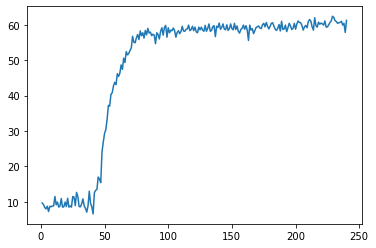

In [8]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [9]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)

# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/caltech101_EfficientNetb620211231002459.pkl
